In [1]:
import SiemensQuadraProperties as sqp
from ActivityTools import *
from SimulationDataset import *

import multiprocessing as mp
mp.set_start_method('fork')

from multiprocessing import Pool
import random
import numpy as np
import matplotlib.pyplot as mpl
myColours=[]
for colour in mpl.cm.viridis( np.linspace( 0.05, 0.8, 4 ) ):
    myColours.append( colour )
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=myColours)

params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

The NEMU NU 2-2012 calculation for variation of NECR with source activity, although now we are only interested in the maximum value

In [2]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, detectorMaterial, simulationWindow=1E-2, coincidenceWindow=4.7E-9 ):
    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2

    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm

    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 20E6, timeSec )

        activityList = []
        dataList = []
        # Hanna: Add crystalActivity to the activityList only if the crystal material is radioactive
        if detectorMaterial == "LSO" or detectorMaterial == "LYSO" :
            activityList = [activity, crystalActivity]
            dataList = [tracerData, crystalData]
        else :
            activityList = [activity]
            dataList = [tracerData]
        necr, true, rPlusS, scatters, randoms = DetectedCoincidences( activityList, dataList, simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )

    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

def NECRatTimeZr89( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, detectorMaterial, simulationWindow=1E-2, coincidenceWindow=4.7E-9 ):
    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2

    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm

    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = Zr89ActivityAtTime( 20E6, timeSec )

        activityList = []
        dataList = []
        # Hanna: Add crystalActivity to the activityList only if the crystal material is radioactive
        if detectorMaterial == "LSO" or detectorMaterial == "LYSO" :
            activityList = [activity, crystalActivity]
            dataList = [tracerData, crystalData]
        else :
            activityList = [activity]
            dataList = [tracerData]
        necr, true, rPlusS, scatters, randoms = DetectedCoincidences( activityList, dataList, simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )

    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

WARNING: this calculation will take a long time

We choose a range of test detector lengths (the real lengths are calculated using discrete detector component sizes) and for each one find the peak NECR value with a given source. We then repeat for a range of different source isotopes. This requires a large amount of simulation and calculation of the decay coincidences.

Both the simulation window size and the dataset size will have a significant impact on the total calculation time. Existing datasets will be re-used automatically (mitigating this issue somewhat) and the simulation window has the greatest effect on statistical fluctuation in the result (10ms window recommended, but this will be slow)

Although the simulation and the coincidence calculation are single-threaded, they can be run completely in parallel. A simple multiprocessing model gives close to ideal scaling - 10 processes are used by default, but adjust this to suit your system

In [3]:
# Investigate ideal detector length with Siemens geometry
def OneDetector( detectorLength, phantomLength, detectorMaterial, isotope, simulationWindow=1E-2, coincidenceWindow=4.7E-9 ):
    tracerName = "Linear" + isotope
    isotopeMethod = NECRatTimeF18
    if isotope == "Zr89":
        isotopeMethod = NECRatTimeZr89
    # Fix random seed for reproducibility, don't if you want variation
    # Has to be set in this method, not before, because this is where we enter the worker processes
    random.seed( detectorLength )
    tracerData = CreateDataset( detectorLength, "Siemens", phantomLength, tracerName, 100000, 435.0, 585.0, detectorMaterial )
    crystalData = None
    crystalActivity = None
    #calculate crystal activity and create crystalDataset only if the crystal is radioactive
    if detectorMaterial == "LSO" or detectorMaterial == "LYSO" :
        crystalActivity= sqp.Lu176decaysInMass( sqp.DetectorMassLength( detectorLength, detectorMaterial ) )
        crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", 100000, 435.0, 585.0, detectorMaterial )

    activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens = isotopeMethod( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, detectorMaterial, simulationWindow, coincidenceWindow )
    return ( max( necrAtTimeSiemens ), sqp.DetectorDiscreteLength( detectorLength ) )

def PeakNECRWithLengthMultiprocess( phantomLength, detectorMaterial, isotope, simulationWindow=1E-2, coincidenceWindow=4.7E-9, processes=5 ):
    # Create the arguments for each process
    detectorLengths = [ 100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900 ]
    arguments = []
    realLengths = []
    maxNECR = []
    for detectorLength in detectorLengths:
        arguments.append( ( detectorLength, phantomLength, detectorMaterial, isotope, simulationWindow, coincidenceWindow ) )
        # result = OneDetector(detectorLength, phantomLength, detectorMaterial, simulationWindow, coincidenceWindow)
        # maxNECR.append(result[0])
        # realLengths.append(result[1])
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( OneDetector, arguments )

    # Unpack the results
    realLengths = []
    maxNECR = []
    for entry in result:
        maxNECR.append( entry[0] )
        realLengths.append( entry[1] )
    return realLengths, maxNECR

detectorLengths = []
maxNECRlines = []
detectorMaterial = "LSO"
isotopes = [ "F18", "Zr89" ]
for isotope in isotopes:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( 700, detectorMaterial, isotope, simulationWindow=1E-2 )
    maxNECRlines.append( maxNECR )

Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation




6515.0 events loaded (100000 simulated) with average 1.0204144282425172 hits/event
Re-using previous simulation
15361.0 events loaded (100000 simulated) with average 1.0506477442874813 hits/event
Re-using previous simulation
22582.0 events loaded (100000 simulated) with average 1.0795766539721903 hits/event
Re-using previous simulation
10696.0 events loaded (100000 simulated) with average 1.0051421091997008 hits/event
28220.0 events loaded (100000 simulated) with average 1.1105953224663359 hits/event
Re-using previous simulation
33044.0 events loaded (100000 simulated) with average 1.1401162086914418 hits/event
Re-using previous simulation
10606.0 events loaded (100000 simulated) with average 1.007731472751273 hits/event
10646.0 events loaded (100000 simulated) with average 1.007420627465715 hits/event
10843.0 events loaded (100000 simulated) 

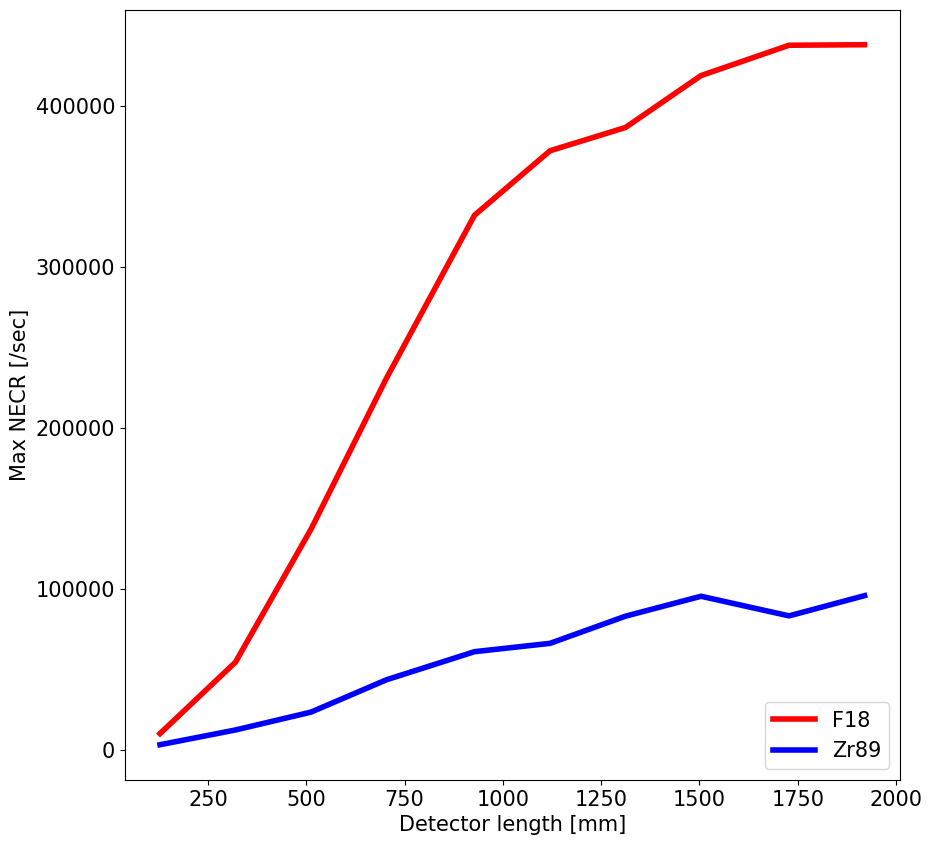

In [4]:
mpl.plot( detectorLengths, maxNECRlines[0], label=isotope[0], color='r', linewidth=4.0 )
mpl.plot( detectorLengths, maxNECRlines[1], label=isotope[1], color='b', linewidth=4.0 )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( isotopes )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()

You can see the max NECR value for F18 has a similar trend at ~4x the value for Zr89. This is expected given only 23% of Zr89 decays emit a positron https://www.mdpi.com/1422-0067/21/12/4309

Yoon JK, Park BN, Ryu EK, An YS, Lee SJ. Current perspectives on 89Zr-PET imaging. International Journal of Molecular Sciences. 2020 Jan;21(12):4309.

Repeat the F18 study of NECR variation with detector and source lengths, but for Zr89

In [5]:
detectorLengths = []
maxNECRlines = []
trialPhantoms = [ 300, 700, 1100, 1500 ]
for phantomLength in trialPhantoms:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( phantomLength, detectorMaterial, "Zr89", simulationWindow=1E-2 )
    maxNECRlines.append( maxNECR )

Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation




3046.0 events loaded (100000 simulated) with average 1.0357846355876559 hits/event
Re-using previous simulation
6863.0 events loaded (100000 simulated) with average 1.0789742095293604 hits/event
Re-using previous simulation
10021.0 events loaded (100000 simulated) with average 1.1194491567707814 hits/event
Re-using previous simulation
12263.0 events loaded (100000 simulated) with average 1.1333278969257115 hits/event
Re-using previous simulation14128.0 events loaded (100000 simulated) with average 1.1482870894677237 hits/event

Re-using previous simulation
10689.0 events loaded (100000 simulated) with average 1.0050519225371877 hits/event
10544.0 events loaded (100000 simulated) with average 1.0072078907435509 hits/event
10687.0 events loaded (100000 simulated) with average 1.0060821558903341 hits/event
10824.0 events loaded (100000 simulated)

12941.0 events loaded (100000 simulated) with average 1.112896994049919 hits/event
Re-using previous simulation
10824.0 events loaded (100000 simulated) with average 1.0067442719881745 hits/event
Re-using previous simulation
14323.0 events loaded (100000 simulated) with average 1.1221112895343155 hits/event
Re-using previous simulation
10643.0 events loaded (100000 simulated) with average 1.0075166776284883 hits/event
Re-using previous simulation
15299.0 events loaded (100000 simulated) with average 1.1339956859925486 hits/event
Re-using previous simulation
10706.0 events loaded (100000 simulated) with average 1.0070054175228844 hits/event
Re-using previous simulation
15830.0 events loaded (100000 simulated) with average 1.1425142135186355 hits/event
Re-using previous simulation
10904.0 events loaded (100000 simulated) with average 1.007061628760088 hits/event


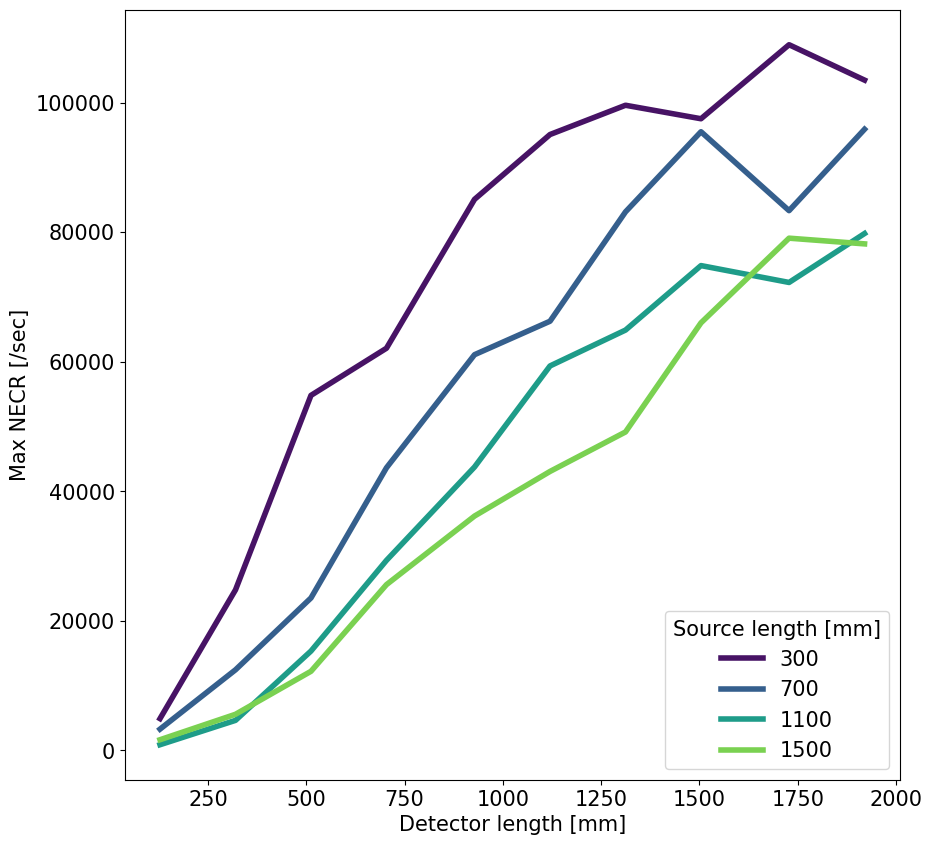

In [6]:
for i, phantomLength in enumerate( trialPhantoms ):
    mpl.plot( detectorLengths, maxNECRlines[i], label=phantomLength, linewidth=4.0 )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()

Illustrate the scaling of NECR up to the source length, and beyond

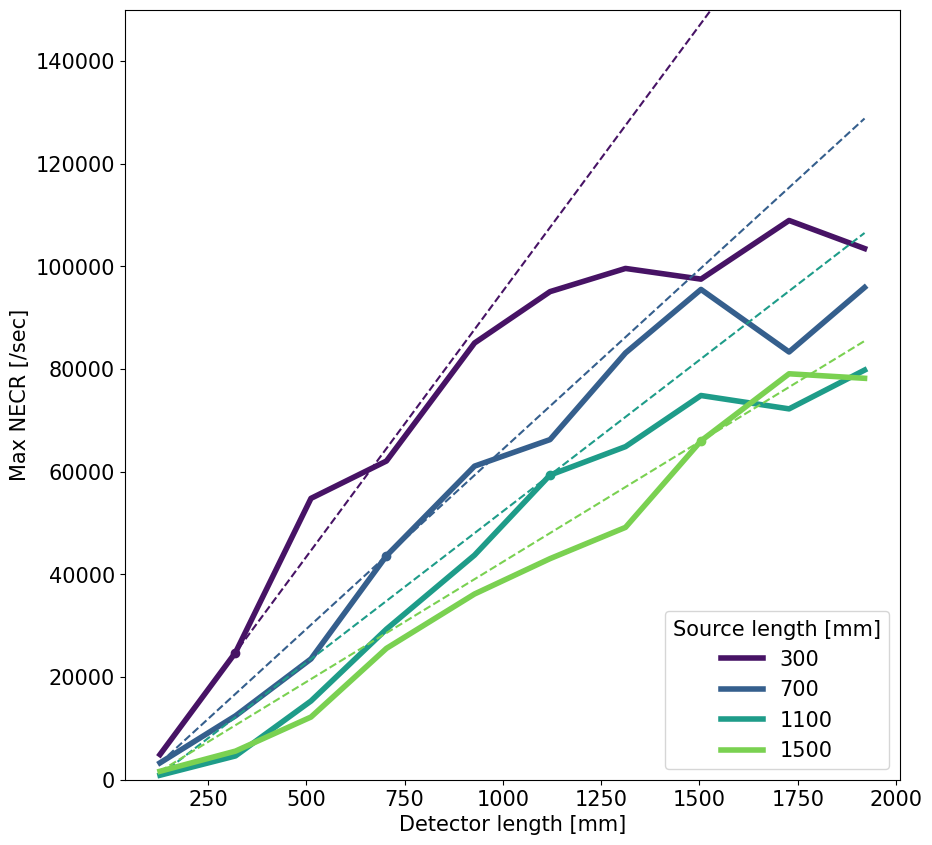

In [7]:
def scale( y0, y1, x1 ):
    m = (y1 - y0) / (x1 - detectorLengths[0])
    y2 = m * ( detectorLengths[-1] - x1 )
    y2 += y1
    return [ y0, y2 ]

def plotThreeParts( xs, ys, i, label, colour ):
    theplot, = mpl.plot( xs, ys, label=label, color=colour, linewidth=4.0 )
    mpl.plot( [xs[0], xs[-1]], scale(ys[0], ys[i], xs[i]), label="_", color=colour, linestyle="dashed" )
    mpl.scatter( [xs[i]], [ys[i]], label="_", color=colour )
    return theplot

legendEntries = []
for i, trialPhantom in enumerate( trialPhantoms ):
    
    # find the detector length index closest to the source length
    detectorLengthIndex = 0
    while detectorLengths[ detectorLengthIndex ] < trialPhantom:
        detectorLengthIndex += 1
    
    theplot = plotThreeParts( detectorLengths, maxNECRlines[i], detectorLengthIndex, trialPhantoms[i], myColours[i] )
    legendEntries.append( theplot )

mpl.xlabel( "Detector length [mm]")
mpl.ylabel( "Max NECR [/sec]")
mpl.legend( legendEntries, trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches(10,10)
mpl.ylim( [0.0, 1.5e5] )
mpl.show()